<a href="https://colab.research.google.com/github/nisha1365/Sanofi-POC/blob/main/Topic_modelling_without_hemophilia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tweet-preprocessor
!pip install bertopic

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# import tweet preprocessor
import preprocessor as p

import nltk
import gensim
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from bertopic import BERTopic
#from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
#from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from bertopic.vectorizers import ClassTfidfTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/my_data.csv")
df

Unnamed: 0             tweet_id  external_twitter_id  \
0               0              1030258         1.684840e+18   
1               1              1030186         1.684590e+18   
2               2              1030263         1.684810e+18   
3               3              1030274         1.684720e+18   
4               4              1030288         1.684660e+18   
...           ...                  ...                  ...   
29798       29798  1683839551645814784                  NaN   
29799       29799  1683938283003183104                  NaN   
29800       29800  1683861079674195968                  NaN   
29801       29801  1683918306082955264                  NaN   
29802       29802  1683834001562140672                  NaN   

                                                    text     author_id  \
0      3 peaks Challenge #AxioActive💪\n\nOn the 12th ...  9.050890e+17   
1      Roche Drops Hemophilia A Candidate, Prepares f...  7.638583e+07   
2      Roche moves one Spark hemophilia gene therapy ...  1.481280e+18   
3      On #WorldHepatitisDay we put middle finger up ...  1.145270e+18   
4      One of our newest internship programs, launche...  2.112887e+08   
...                                                  ...           ...   
29798  Hear more from Mosi Williams, Pys.D, on the la...  1.479181e+18   
29799  Was discussing hemophilia with an intelligent,...  2.760856e+08   
29800  The affected &amp; infected have waited decade...  1.104181e+08   
29801  @MohmdBio Sickle cell anemia, Thalassemia, Hem...  1.179873e+18   
29802  Save the date to “tee up for a cure” on Monday...  4.867600e+08   

                created_at lang  referenced_tweets_type  referenced_tweets_id  \
0         28-07-2023 08:18   en                       0          0.000000e+00   
1         27-07-2023 15:51   en                       0          0.000000e+00   
2         28-07-2023 06:34   en                       0          0.000000e+00   
3         28-07-2023 00:27   en                       0          0.000000e+00   
4         27-07-2023 20:13   en                       3          1.684630e+18   
...                    ...  ...                     ...                   ...   
29798  2023-07-25 14:00:07   en                       0          0.000000e+00   
29799  2023-07-25 20:32:27   en                       0          0.000000e+00   
29800  2023-07-25 15:25:40   en                       3          1.683849e+18   
29801  2023-07-25 19:13:04   en                       2          1.683918e+18   
29802  2023-07-25 13:38:04   en                       0          0.000000e+00   

      infos  association_tweet_id  association_scope_id  
0        {}               1030258                    10  
1        {}               1030186                    10  
2        {}               1030263                    10  
3        {}               1030274                    10  
4        {}               1030288                    10  
...     ...                   ...                   ...  
29798    {}   1683839551645814784                    10  
29799    {}   1683938283003183104                    10  
29800    {}   1683861079674195968                    10  
29801    {}   1683918306082955264                    10  
29802    {}   1683834001562140672                    10  

[29803 rows x 12 columns]

In [ ]:
columns_to_keep = ['author_id','tweet_id','text','created_at']

new_df = df[columns_to_keep]
new_df

author_id             tweet_id  \
0      9.050890e+17              1030258   
1      7.638583e+07              1030186   
2      1.481280e+18              1030263   
3      1.145270e+18              1030274   
4      2.112887e+08              1030288   
...             ...                  ...   
29798  1.479181e+18  1683839551645814784   
29799  2.760856e+08  1683938283003183104   
29800  1.104181e+08  1683861079674195968   
29801  1.179873e+18  1683918306082955264   
29802  4.867600e+08  1683834001562140672   

                                                    text           created_at  
0      3 peaks Challenge #AxioActive💪\n\nOn the 12th ...     28-07-2023 08:18  
1      Roche Drops Hemophilia A Candidate, Prepares f...     27-07-2023 15:51  
2      Roche moves one Spark hemophilia gene therapy ...     28-07-2023 06:34  
3      On #WorldHepatitisDay we put middle finger up ...     28-07-2023 00:27  
4      One of our newest internship programs, launche...     27-07-2023 20:13  
...                                                  ...                  ...  
29798  Hear more from Mosi Williams, Pys.D, on the la...  2023-07-25 14:00:07  
29799  Was discussing hemophilia with an intelligent,...  2023-07-25 20:32:27  
29800  The affected &amp; infected have waited decade...  2023-07-25 15:25:40  
29801  @MohmdBio Sickle cell anemia, Thalassemia, Hem...  2023-07-25 19:13:04  
29802  Save the date to “tee up for a cure” on Monday...  2023-07-25 13:38:04  

[29803 rows x 4 columns]

In [ ]:
import pandas as pd
# Assuming 'created_at' is in string format, convert it to datetime
new_df['created_at_1'] = pd.to_datetime(new_df['created_at'], errors = 'coerce')


# Create a new column for the date, time, and day
new_df['date'] = new_df['created_at_1'].dt.date
new_df['time'] = new_df['created_at_1'].dt.time
new_df['day_of_week'] = new_df['created_at_1'].dt.day_name()
# Display the updated DataFrame
new_df

author_id             tweet_id  \
0      9.050890e+17              1030258   
1      7.638583e+07              1030186   
2      1.481280e+18              1030263   
3      1.145270e+18              1030274   
4      2.112887e+08              1030288   
...             ...                  ...   
29798  1.479181e+18  1683839551645814784   
29799  2.760856e+08  1683938283003183104   
29800  1.104181e+08  1683861079674195968   
29801  1.179873e+18  1683918306082955264   
29802  4.867600e+08  1683834001562140672   

                                                    text           created_at  \
0      3 peaks Challenge #AxioActive💪\n\nOn the 12th ...     28-07-2023 08:18   
1      Roche Drops Hemophilia A Candidate, Prepares f...     27-07-2023 15:51   
2      Roche moves one Spark hemophilia gene therapy ...     28-07-2023 06:34   
3      On #WorldHepatitisDay we put middle finger up ...     28-07-2023 00:27   
4      One of our newest internship programs, launche...     27-07-2023 20:13   
...                                                  ...                  ...   
29798  Hear more from Mosi Williams, Pys.D, on the la...  2023-07-25 14:00:07   
29799  Was discussing hemophilia with an intelligent,...  2023-07-25 20:32:27   
29800  The affected &amp; infected have waited decade...  2023-07-25 15:25:40   
29801  @MohmdBio Sickle cell anemia, Thalassemia, Hem...  2023-07-25 19:13:04   
29802  Save the date to “tee up for a cure” on Monday...  2023-07-25 13:38:04   

             created_at_1        date      time day_of_week  
0     2023-07-28 08:18:00  2023-07-28  08:18:00      Friday  
1     2023-07-27 15:51:00  2023-07-27  15:51:00    Thursday  
2     2023-07-28 06:34:00  2023-07-28  06:34:00      Friday  
3     2023-07-28 00:27:00  2023-07-28  00:27:00      Friday  
4     2023-07-27 20:13:00  2023-07-27  20:13:00    Thursday  
...                   ...         ...       ...         ...  
29798 2023-07-25 14:00:07  2023-07-25  14:00:07     Tuesday  
29799 2023-07-25 20:32:27  2023-07-25  20:32:27     Tuesday  
29800 2023-07-25 15:25:40  2023-07-25  15:25:40     Tuesday  
29801 2023-07-25 19:13:04  2023-07-25  19:13:04     Tuesday  
29802 2023-07-25 13:38:04  2023-07-25  13:38:04     Tuesday  

[29803 rows x 8 columns]

In [ ]:
my_frame = new_df.loc[:, ['author_id', 'tweet_id','text', 'created_at','created_at_1']]
my_frame

author_id             tweet_id  \
0      9.050890e+17              1030258   
1      7.638583e+07              1030186   
2      1.481280e+18              1030263   
3      1.145270e+18              1030274   
4      2.112887e+08              1030288   
...             ...                  ...   
29798  1.479181e+18  1683839551645814784   
29799  2.760856e+08  1683938283003183104   
29800  1.104181e+08  1683861079674195968   
29801  1.179873e+18  1683918306082955264   
29802  4.867600e+08  1683834001562140672   

                                                    text           created_at  \
0      3 peaks Challenge #AxioActive💪\n\nOn the 12th ...     28-07-2023 08:18   
1      Roche Drops Hemophilia A Candidate, Prepares f...     27-07-2023 15:51   
2      Roche moves one Spark hemophilia gene therapy ...     28-07-2023 06:34   
3      On #WorldHepatitisDay we put middle finger up ...     28-07-2023 00:27   
4      One of our newest internship programs, launche...     27-07-2023 20:13   
...                                                  ...                  ...   
29798  Hear more from Mosi Williams, Pys.D, on the la...  2023-07-25 14:00:07   
29799  Was discussing hemophilia with an intelligent,...  2023-07-25 20:32:27   
29800  The affected &amp; infected have waited decade...  2023-07-25 15:25:40   
29801  @MohmdBio Sickle cell anemia, Thalassemia, Hem...  2023-07-25 19:13:04   
29802  Save the date to “tee up for a cure” on Monday...  2023-07-25 13:38:04   

             created_at_1  
0     2023-07-28 08:18:00  
1     2023-07-27 15:51:00  
2     2023-07-28 06:34:00  
3     2023-07-28 00:27:00  
4     2023-07-27 20:13:00  
...                   ...  
29798 2023-07-25 14:00:07  
29799 2023-07-25 20:32:27  
29800 2023-07-25 15:25:40  
29801 2023-07-25 19:13:04  
29802 2023-07-25 13:38:04  

[29803 rows x 5 columns]

In [ ]:
my_frame.isnull().sum()

author_id       0
tweet_id        0
text            0
created_at      0
created_at_1    0
dtype: int64

In [ ]:
my_frame.shape

(29803, 5)

In [ ]:
# Filter rows where the 'text' column does not contain the word Hemophilia
#filtered_df = my_frame[~my_frame['text'].str.contains('Hemophilia', case = False)]

#data_tweet = filtered_df[['author_id','tweet_id','text','created_at','created_at_1']]

#data_tweet


author_id             tweet_id  \
0      9.050890e+17              1030258   
3      1.145270e+18              1030274   
6      3.982399e+07              1030291   
8      1.950975e+07              1030261   
12     1.111210e+18              1030271   
...             ...                  ...   
29784  1.479844e+08  1682878464179814405   
29785  8.797817e+17  1683027955465822208   
29790  3.982399e+07  1682734259553935360   
29791  1.424436e+18  1683834662937047040   
29800  1.104181e+08  1683861079674195968   

                                                    text           created_at  \
0      3 peaks Challenge #AxioActive💪\n\nOn the 12th ...     28-07-2023 08:18   
3      On #WorldHepatitisDay we put middle finger up ...     28-07-2023 00:27   
6      Learn about the importance patient safety in t...     27-07-2023 19:59   
8      @physio_paul many congratulations well deserve...     28-07-2023 07:11   
12     @SuperDLM515 @GinaMcGalliard The royals can't ...     28-07-2023 01:32   
...                                                  ...                  ...   
29784  Rishi Sunak and a raft of ministers will be ha...  2023-07-22 22:21:06   
29785  "In 1978, doctors knew that using people with ...  2023-07-23 08:15:08   
29790  #ICYMI: Yesterday was #ZEROHIVStigmaDay. Learn...  2023-07-22 12:48:05   
29791  2/3\n\nAs just one example, check out how diff...  2023-07-25 13:40:42   
29800  The affected &amp; infected have waited decade...  2023-07-25 15:25:40   

             created_at_1  
0     2023-07-28 08:18:00  
3     2023-07-28 00:27:00  
6     2023-07-27 19:59:00  
8     2023-07-28 07:11:00  
12    2023-07-28 01:32:00  
...                   ...  
29784 2023-07-22 22:21:06  
29785 2023-07-23 08:15:08  
29790 2023-07-22 12:48:05  
29791 2023-07-25 13:40:42  
29800 2023-07-25 15:25:40  

[8970 rows x 5 columns]

In [ ]:
# Filter rows where the 'text' column does not contain both 'Hemophilia' and 'Haemophilia'
filtered_df = my_frame[~(my_frame['text'].str.contains('Hemophilia', case=False) | my_frame['text'].str.contains('Haemophilia', case=False))]

# Select the specified columns
data_tweet = filtered_df[['author_id', 'tweet_id', 'text', 'created_at', 'created_at_1']]
data_tweet

author_id             tweet_id  \
6      3.982399e+07              1030291   
24     7.989210e+17              1030201   
25     1.489028e+09              1030276   
33     9.471910e+17              1030297   
45     6.161019e+07              1030290   
...             ...                  ...   
29758  2.349022e+07  1682882509082689536   
29776  7.584146e+07  1682715629185368065   
29778  5.744698e+07  1683028659261538305   
29790  3.982399e+07  1682734259553935360   
29791  1.424436e+18  1683834662937047040   

                                                    text           created_at  \
6      Learn about the importance patient safety in t...     27-07-2023 19:59   
24     New #RPTH study reports on FVIII inhibitors lo...     27-07-2023 13:38   
25     Today is #WorldHepatitisDay. Alex has #VWD. He...     28-07-2023 00:15   
33     Roche has discontinued development of the Gene...     27-07-2023 18:07   
45     Our Disaster Relief program provides immediate...     27-07-2023 20:00   
...                                                  ...                  ...   
29758  Here's what we had to face in the 1980s, we wh...  2023-07-22 22:37:11   
29776  @Bonniecharles94 Actually it comes down to you...  2023-07-22 11:34:03   
29778  @NicotineLozeng @TheRealMilkCo @karlrgibson1 @...  2023-07-23 08:17:56   
29790  #ICYMI: Yesterday was #ZEROHIVStigmaDay. Learn...  2023-07-22 12:48:05   
29791  2/3\n\nAs just one example, check out how diff...  2023-07-25 13:40:42   

             created_at_1  
6     2023-07-27 19:59:00  
24    2023-07-27 13:38:00  
25    2023-07-28 00:15:00  
33    2023-07-27 18:07:00  
45    2023-07-27 20:00:00  
...                   ...  
29758 2023-07-22 22:37:11  
29776 2023-07-22 11:34:03  
29778 2023-07-23 08:17:56  
29790 2023-07-22 12:48:05  
29791 2023-07-25 13:40:42  

[2405 rows x 5 columns]

In [ ]:
data_tweet.shape

(2405, 5)

In [ ]:
data_tweet.isnull().sum()

author_id       0
tweet_id        0
text            0
created_at      0
created_at_1    0
dtype: int64

In [ ]:
data_tweet.dtypes

author_id              float64
tweet_id                 int64
text                    object
created_at              object
created_at_1    datetime64[ns]
dtype: object

In [ ]:
# Customizing the preprocessor to exclude removing hashtags since they are valuable as a rich information
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.SMILEY,p.OPT.NUMBER )

data_tweet['new_text']  = data_tweet['text'].apply(lambda x: p.clean(str(x)) if pd.notna(x) else '')

In [ ]:
data_tweet

author_id             tweet_id  \
6      3.982399e+07              1030291   
24     7.989210e+17              1030201   
25     1.489028e+09              1030276   
33     9.471910e+17              1030297   
45     6.161019e+07              1030290   
...             ...                  ...   
29758  2.349022e+07  1682882509082689536   
29776  7.584146e+07  1682715629185368065   
29778  5.744698e+07  1683028659261538305   
29790  3.982399e+07  1682734259553935360   
29791  1.424436e+18  1683834662937047040   

                                                    text           created_at  \
6      Learn about the importance patient safety in t...     27-07-2023 19:59   
24     New #RPTH study reports on FVIII inhibitors lo...     27-07-2023 13:38   
25     Today is #WorldHepatitisDay. Alex has #VWD. He...     28-07-2023 00:15   
33     Roche has discontinued development of the Gene...     27-07-2023 18:07   
45     Our Disaster Relief program provides immediate...     27-07-2023 20:00   
...                                                  ...                  ...   
29758  Here's what we had to face in the 1980s, we wh...  2023-07-22 22:37:11   
29776  @Bonniecharles94 Actually it comes down to you...  2023-07-22 11:34:03   
29778  @NicotineLozeng @TheRealMilkCo @karlrgibson1 @...  2023-07-23 08:17:56   
29790  #ICYMI: Yesterday was #ZEROHIVStigmaDay. Learn...  2023-07-22 12:48:05   
29791  2/3\n\nAs just one example, check out how diff...  2023-07-25 13:40:42   

             created_at_1                                           new_text  
6     2023-07-27 19:59:00  Learn about the importance patient safety in t...  
24    2023-07-27 13:38:00  New #RPTH study reports on FVIII inhibitors lo...  
25    2023-07-28 00:15:00  Today is #WorldHepatitisDay. Alex has #VWD. He...  
33    2023-07-27 18:07:00  Roche has discontinued development of the Gene...  
45    2023-07-27 20:00:00  Our Disaster Relief program provides immediate...  
...                   ...                                                ...  
29758 2023-07-22 22:37:11  Here's what we had to face in the s, we who ro...  
29776 2023-07-22 11:34:03  Actually it comes down to your ABR. In general...  
29778 2023-07-23 08:17:56                                         Like this?  
29790 2023-07-22 12:48:05  #ICYMI: Yesterday was #ZEROHIVStigmaDay. Learn...  
29791 2023-07-25 13:40:42  /3 As just one example, check out how differen...  

[2405 rows x 6 columns]

In [ ]:
data_tweet.isnull().sum()

author_id       0
tweet_id        0
text            0
created_at      0
created_at_1    0
new_text        0
dtype: int64

In [ ]:
#REMOVE ONLY THE '#'NOT THE WORD AFTER
def remove_hashtag_sign(text):
    text = re.sub(r'#', '', text)
    return text

data_tweet['new_text'] = data_tweet['new_text'].apply(lambda x:remove_hashtag_sign(x))

In [ ]:
#Remove extra white spaces, punctuation and apply lower casing
data_tweet['new_text'] = data_tweet['new_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
data_tweet.head()

author_id  tweet_id                                               text  \
6   3.982399e+07   1030291  Learn about the importance patient safety in t...   
24  7.989210e+17   1030201  New #RPTH study reports on FVIII inhibitors lo...   
25  1.489028e+09   1030276  Today is #WorldHepatitisDay. Alex has #VWD. He...   
33  9.471910e+17   1030297  Roche has discontinued development of the Gene...   
45  6.161019e+07   1030290  Our Disaster Relief program provides immediate...   

          created_at        created_at_1  \
6   27-07-2023 19:59 2023-07-27 19:59:00   
24  27-07-2023 13:38 2023-07-27 13:38:00   
25  28-07-2023 00:15 2023-07-28 00:15:00   
33  27-07-2023 18:07 2023-07-27 18:07:00   
45  27-07-2023 20:00 2023-07-27 20:00:00   

                                             new_text  
6   learn about the importance patient safety in t...  
24  new rpth study reports on fviii inhibitors lon...  
25  today is worldhepatitisday alex has vwd he spe...  
33  roche has discontinued development of the gene...  
45  our disaster relief program provides immediate...

In [ ]:
data_tweet.shape

(2405, 6)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(text):
  """Lemmatizes a text.

  Args:
    text: The text to lemmatize.

  Returns:
    The lemmatized text.
  """

  words = nltk.word_tokenize(text)
  lemmas = [nltk.WordNetLemmatizer().lemmatize(word) for word in words]
  return " ".join(lemmas)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
data_tweet['new_lemma_text'] = data_tweet["new_text"].apply(lemmatize_text)

In [ ]:
data_tweet

author_id             tweet_id  \
6      3.982399e+07              1030291   
24     7.989210e+17              1030201   
25     1.489028e+09              1030276   
33     9.471910e+17              1030297   
45     6.161019e+07              1030290   
...             ...                  ...   
29758  2.349022e+07  1682882509082689536   
29776  7.584146e+07  1682715629185368065   
29778  5.744698e+07  1683028659261538305   
29790  3.982399e+07  1682734259553935360   
29791  1.424436e+18  1683834662937047040   

                                                    text           created_at  \
6      Learn about the importance patient safety in t...     27-07-2023 19:59   
24     New #RPTH study reports on FVIII inhibitors lo...     27-07-2023 13:38   
25     Today is #WorldHepatitisDay. Alex has #VWD. He...     28-07-2023 00:15   
33     Roche has discontinued development of the Gene...     27-07-2023 18:07   
45     Our Disaster Relief program provides immediate...     27-07-2023 20:00   
...                                                  ...                  ...   
29758  Here's what we had to face in the 1980s, we wh...  2023-07-22 22:37:11   
29776  @Bonniecharles94 Actually it comes down to you...  2023-07-22 11:34:03   
29778  @NicotineLozeng @TheRealMilkCo @karlrgibson1 @...  2023-07-23 08:17:56   
29790  #ICYMI: Yesterday was #ZEROHIVStigmaDay. Learn...  2023-07-22 12:48:05   
29791  2/3\n\nAs just one example, check out how diff...  2023-07-25 13:40:42   

             created_at_1                                           new_text  \
6     2023-07-27 19:59:00  learn about the importance patient safety in t...   
24    2023-07-27 13:38:00  new rpth study reports on fviii inhibitors lon...   
25    2023-07-28 00:15:00  today is worldhepatitisday alex has vwd he spe...   
33    2023-07-27 18:07:00  roche has discontinued development of the gene...   
45    2023-07-27 20:00:00  our disaster relief program provides immediate...   
...                   ...                                                ...   
29758 2023-07-22 22:37:11  here s what we had to face in the s we who rod...   
29776 2023-07-22 11:34:03  actually it comes down to your abr in general ...   
29778 2023-07-23 08:17:56                                         like this    
29790 2023-07-22 12:48:05  icymi yesterday was zerohivstigmaday learn mor...   
29791 2023-07-25 13:40:42   3 as just one example check out how different...   

                                          new_lemma_text  
6      learn about the importance patient safety in t...  
24     new rpth study report on fviii inhibitor longi...  
25     today is worldhepatitisday alex ha vwd he spea...  
33     roche ha discontinued development of the gene ...  
45     our disaster relief program provides immediate...  
...                                                  ...  
29758  here s what we had to face in the s we who rod...  
29776  actually it come down to your abr in general i...  
29778                                          like this  
29790  icymi yesterday wa zerohivstigmaday learn more...  
29791  3 a just one example check out how different l...  

[2405 rows x 7 columns]

In [ ]:
!pip install emoji

In [ ]:
#Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine',random_state=100)

In [ ]:
#Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15,min_samples = 5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
# #Tokenize topics
# nltk.download('stopwords')
# stopwords = stopwords.words('english')
# vectorizer_model = CountVectorizer(stop_words= stopwords)

vectorizer_model = CountVectorizer(stop_words="english")

In [ ]:
#Create topic representation
ctfidf_model = ClassTfidfTransformer()

In [ ]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.3)

topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  representation_model=representation_model,
  nr_topics='auto',
  low_memory=True,
  n_gram_range=(1, 3),
  calculate_probabilities=True,
  verbose=True,
)

In [ ]:
import time

In [ ]:
tweet_list = data_tweet.new_lemma_text.tolist()
timestamp=data_tweet.created_at.tolist()
timestamps=data_tweet.created_at_1.tolist()

In [ ]:
topics, probs = topic_model.fit_transform(tweet_list)

2024-01-29 10:47:43,249 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

2024-01-29 10:48:40,892 - BERTopic - Embedding - Completed ✓
2024-01-29 10:48:40,894 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-29 10:48:52,606 - BERTopic - Dimensionality - Completed ✓
2024-01-29 10:48:52,609 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-29 10:48:53,195 - BERTopic - Cluster - Completed ✓
2024-01-29 10:48:53,197 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-29 10:49:06,376 - BERTopic - Representation - Completed ✓
2024-01-29 10:49:06,377 - BERTopic - Topic reduction - Reducing number of topics
2024-01-29 10:49:13,451 - BERTopic - Topic reduction - Reduced number of topics from 69 to 41


In [ ]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1    311                       -1_apr_data_bleeding_weekend   
1       0    403    0_bleeding_disorder_community_bleedingdisorders   
2       1    331                              1_fviii_fda_viii_gene   
3       2    173                2_eahad2023_congress_delegate_event   
4       3    137          3_compensation_blood_contaminatedblood_mp   
5       4    108                        4_gene_genetherapy_aav_cost   
6       5     65                            5_nhf_donate_kit_bottle   
7       6     42                  6_manchester_city_idea_industrial   
8       7     40           7_chat_community_sisterspace_brotherhood   
9       8     39                       8_sauna_journal_therapy_miss   
10      9     36                      9_mile_challenge_sign_fitness   
11     10     34                  10_webinar_eastern_begin_webinars   
12     11     34                       11_em_photo_eahad2023_poster   
13     12     32                12_willebrand_vwf_disease_inherited   
14     13     32               13_access_denied_register_disability   
15     14     32          14_apply_researcher_accreditation_scoring   
16     15     31               15_insurer_barrier_access_healthcare   
17     16     30                      16_parent_piano_concert_place   
18     17     29  17_woman_psychosocialsession_psychosocial_comfort   
19     18     29                        18_london_day_ticket_booked   
20     19     29            19_medicaid_chip_protectmedicaid_change   
21     20     28                  20_level_vwf_limitation_diagnosis   
22     21     28       21_platelet_inherited_malin_rarediseasemonth   
23     22     26                   22_pfe_ceo_news_financialmarkets   
24     23     25                    23_fviii_game_anticipated_cheat   
25     24     24                         24_thorin_poke_dumb_pretty   
26     25     23          25_assay_product_individualised_switching   
27     26     22        26_deficiency_fibrinogen_nutrient_inherited   
28     27     22                                   27_column_week__   
29     28     22                    28_apply_advocacy_policy_summit   
30     29     21  29_management_vonwillebranddisease_flood_veronica   
31     30     20                  30_committee_nursing_level_dublin   
32     31     20                  31_titled_webinar_health_cannabis   
33     32     18     32_corticosteroid_adrenal_insufficiency_asthma   
34     33     17                 33_iii_unspeakable_cooper_producer   
35     34     16                   34_sport_running_ironman_cycling   
36     35     16             35_variant_genetic_database_chromosome   
37     36     15                     36_webinar_smart_debra_founder   
38     37     15                 37_renewal_medicaid_address_letter   
39     38     15  38_hepatitis_worldhepatitisday_hepcantwaitau_c...   
40     39     15                       39_fantasy_final_fviii_track   

                                       Representation  \
0   [apr, data, bleeding, weekend, aptt, diagnosed...   
1   [bleeding, disorder, community, bleedingdisord...   
2   [fviii, fda, viii, gene, vwf, inhibitor, antib...   
3   [eahad2023, congress, delegate, event, module,...   
4   [compensation, blood, contaminatedblood, mp, s...   
5   [gene, genetherapy, aav, cost, eahad2023, prop...   
6   [nhf, donate, kit, bottle, shoelace, pin, sock...   
7   [manchester, city, idea, industrial, venue, ne...   
8   [chat, community, sisterspace, brotherhood, jo...   
9   [sauna, journal, therapy, miss, casari, treatm...   
10  [mile, challenge, sign, fitness, walk, reached...   
11  [webinar, eastern, begin, webinars, wednesday,...   
12  [em, photo, eahad2023, poster, headstart, uplo...   
13  [willebrand, vwf, disease, inherited, ag, aros...   
14  [access, denied, register, disability, agedcar...   
15  [apply, researcher, accreditation, scoring, cl...   
16  [insurer, barrier, access, healthcare, drugmak..

In [ ]:
topic_model.get_topic(0)

[('bleeding', 0.03949714887313503),
 ('disorder', 0.03857639305461372),
 ('community', 0.029481972691559596),
 ('bleedingdisorders', 0.022218874263744432),
 ('family', 0.01961131560108055),
 ('hfa', 0.016764019191503655),
 ('bleedingdisordersawarenessmonth', 0.015670325133286034),
 ('grant', 0.014878940325834299),
 ('symposium', 0.012677914171370397),
 ('patient', 0.010824634568550531)]

In [ ]:
def get_bert_topics(topic_model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words=topic_model.get_topic(i)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

get_bert_topics(topic_model, len(set(topics))-1)

Topic # 01  Topic # 02    Topic # 03  \
0                         bleeding       fviii     eahad2023   
1                         disorder         fda      congress   
2                        community        viii      delegate   
3                bleedingdisorders        gene         event   
4                           family         vwf        module   
5                              hfa   inhibitor    manchester   
6  bleedingdisordersawarenessmonth    antibody           day   
7                            grant    clinical       meeting   
8                        symposium  hemostasis  eahadacademy   
9                          patient  thrombosis         visit   

          Topic # 04   Topic # 05 Topic # 06  Topic # 07   Topic # 08  \
0       compensation         gene        nhf  manchester         chat   
1              blood  genetherapy     donate        city    community   
2  contaminatedblood          aav        kit        idea  sisterspace   
3                 mp         cost     bottle  industrial  brotherhood   
4            scandal    eahad2023   shoelace       venue         join   
5             victim  prophylaxis        pin  networking     hablando   
6             labour      million       sock       guide      contigo   
7            protest        trial   resource       space       latino   
8                hiv    treatment     spring       ready       sister   
9            blocked      vaccine   reusable     explore      calling   

       Topic # 09 Topic # 10  ...  Topic # 31        Topic # 32  \
0           sauna       mile  ...   committee            titled   
1         journal  challenge  ...     nursing           webinar   
2         therapy       sign  ...       level            health   
3            miss    fitness  ...      dublin          cannabis   
4          casari       walk  ...      review                iq   
5       treatment    reached  ...        role           feature   
6  rarediseaseday   marathon  ...       eahad              join   
7           novel       fund  ...      fenton               bar   
8       diagnosed    glasgow  ...       paola  womenshealthweek   
9       eahad2023      route  ...  evaluating            sanofi   

       Topic # 33   Topic # 34  Topic # 35    Topic # 36 Topic # 37  \
0  corticosteroid          iii       sport       variant    webinar   
1         adrenal  unspeakable     running       genetic      smart   
2   insufficiency       cooper     ironman      database      debra   
3          asthma     producer     cycling    chromosome    founder   
4         steroid       robert    exercise       section      jacob   
5       eahad2023          feb     athlete    testicular    feature   
6       oestrogen      healing  triathlons       missing  financial   
7  hypoadrenalism      convene  wheelchair            xy   wellness   
8      withdrawal        guest    activity  disadvantage  community   
9         hormone     panelist    assessed   documenting        fbf   

  Topic # 38         Topic # 39 Topic # 40  
0    renewal          hepatitis    fantasy  
1   medicaid  worldhepatitisday      final  
2    address      hepcantwaitau      fviii  
3     letter          cirrhosis      track  
4   consumer              cured     knight  
5      moved                hcv      rally  
6      email            hepatic      mario  
7    covid19                hep       jeep  
8       toll          steatosis       hype  
9      alert       hepatologist     tactic  

[10 rows x 40 columns]

In [ ]:
topic_model.visualize_barchart(top_n_topics=10, n_words = 10)

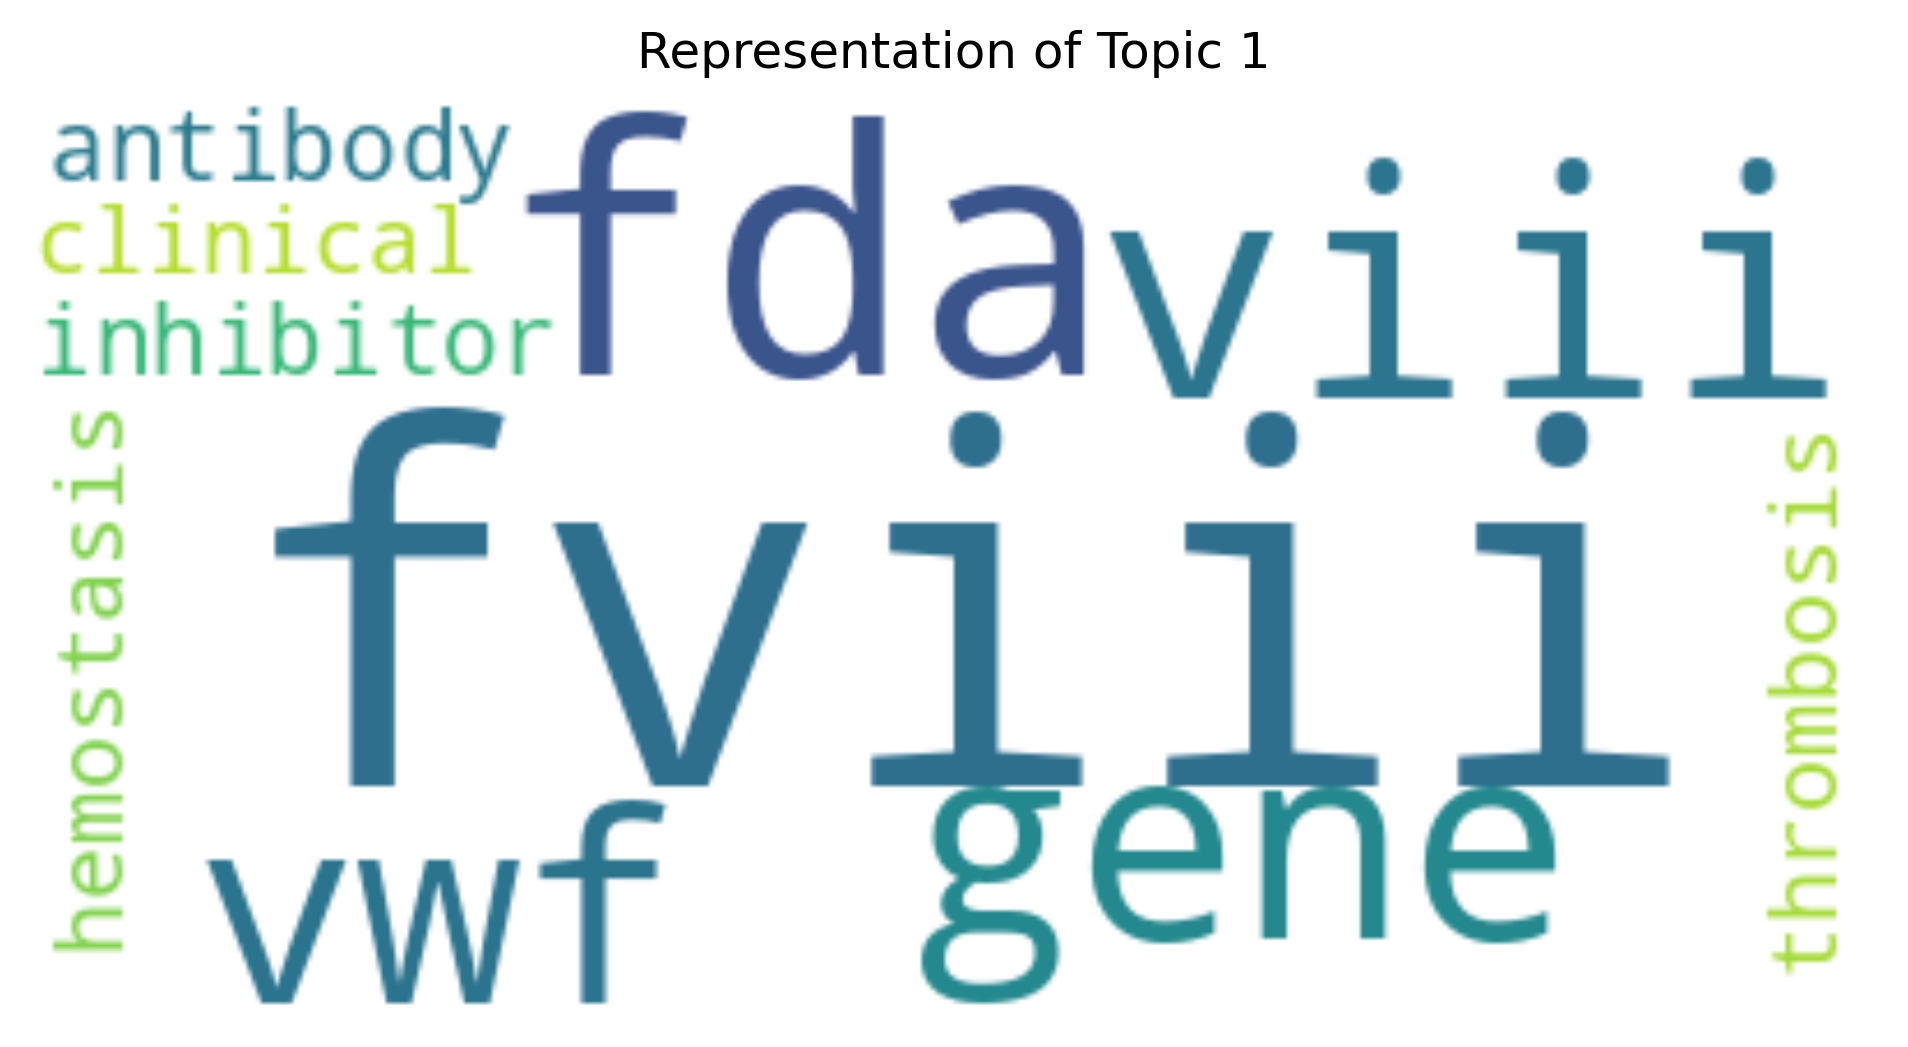

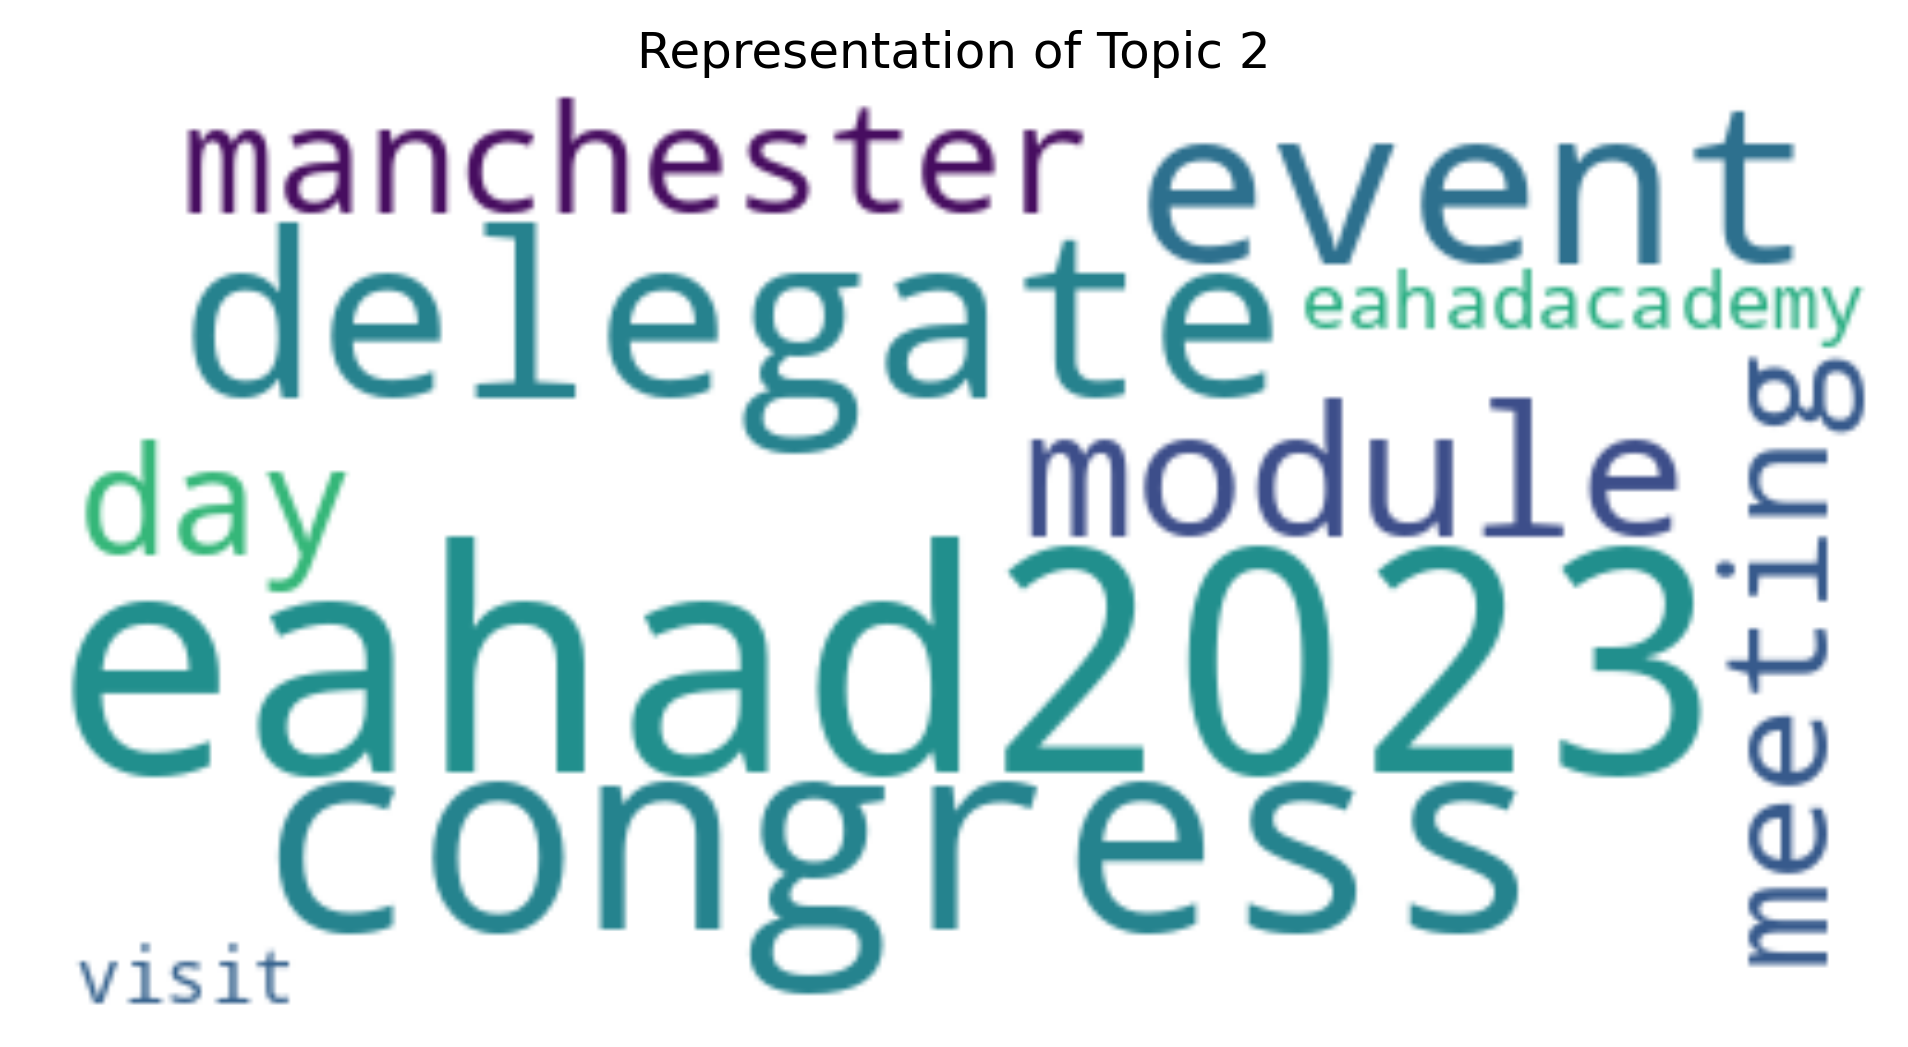

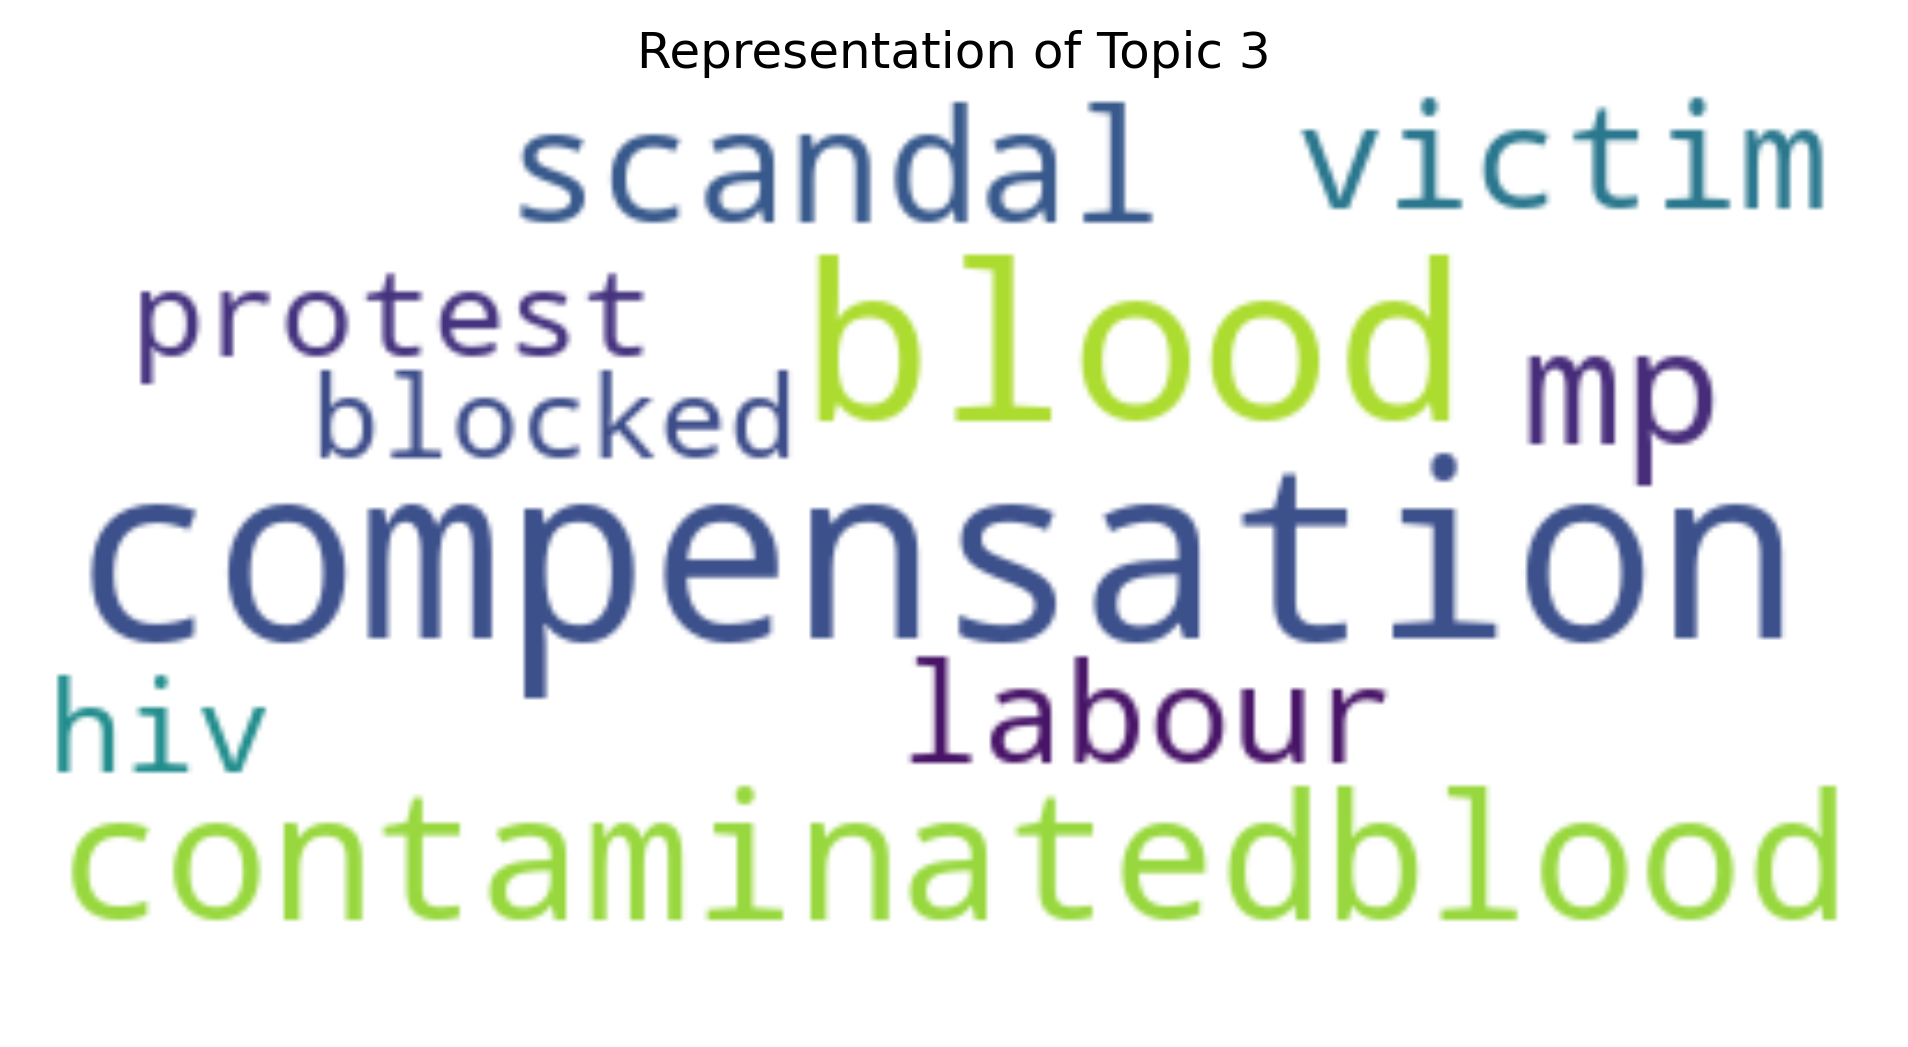

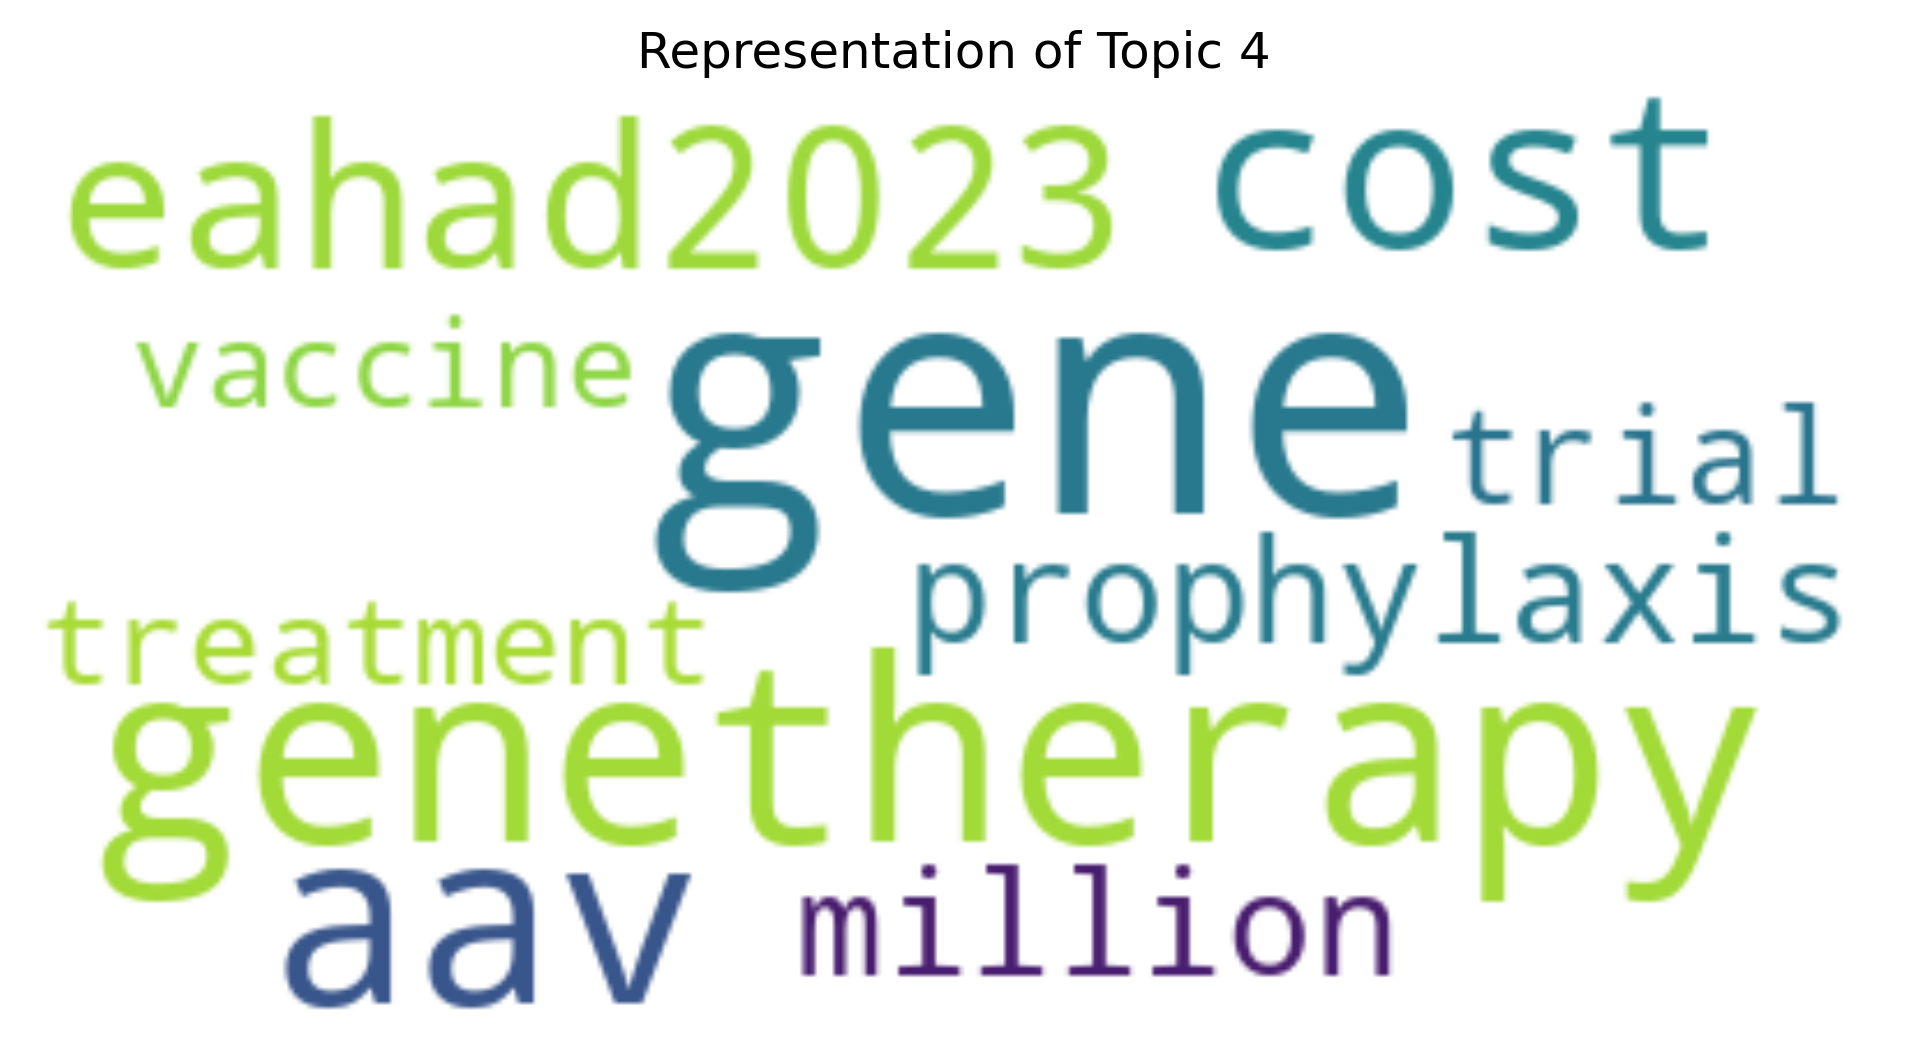

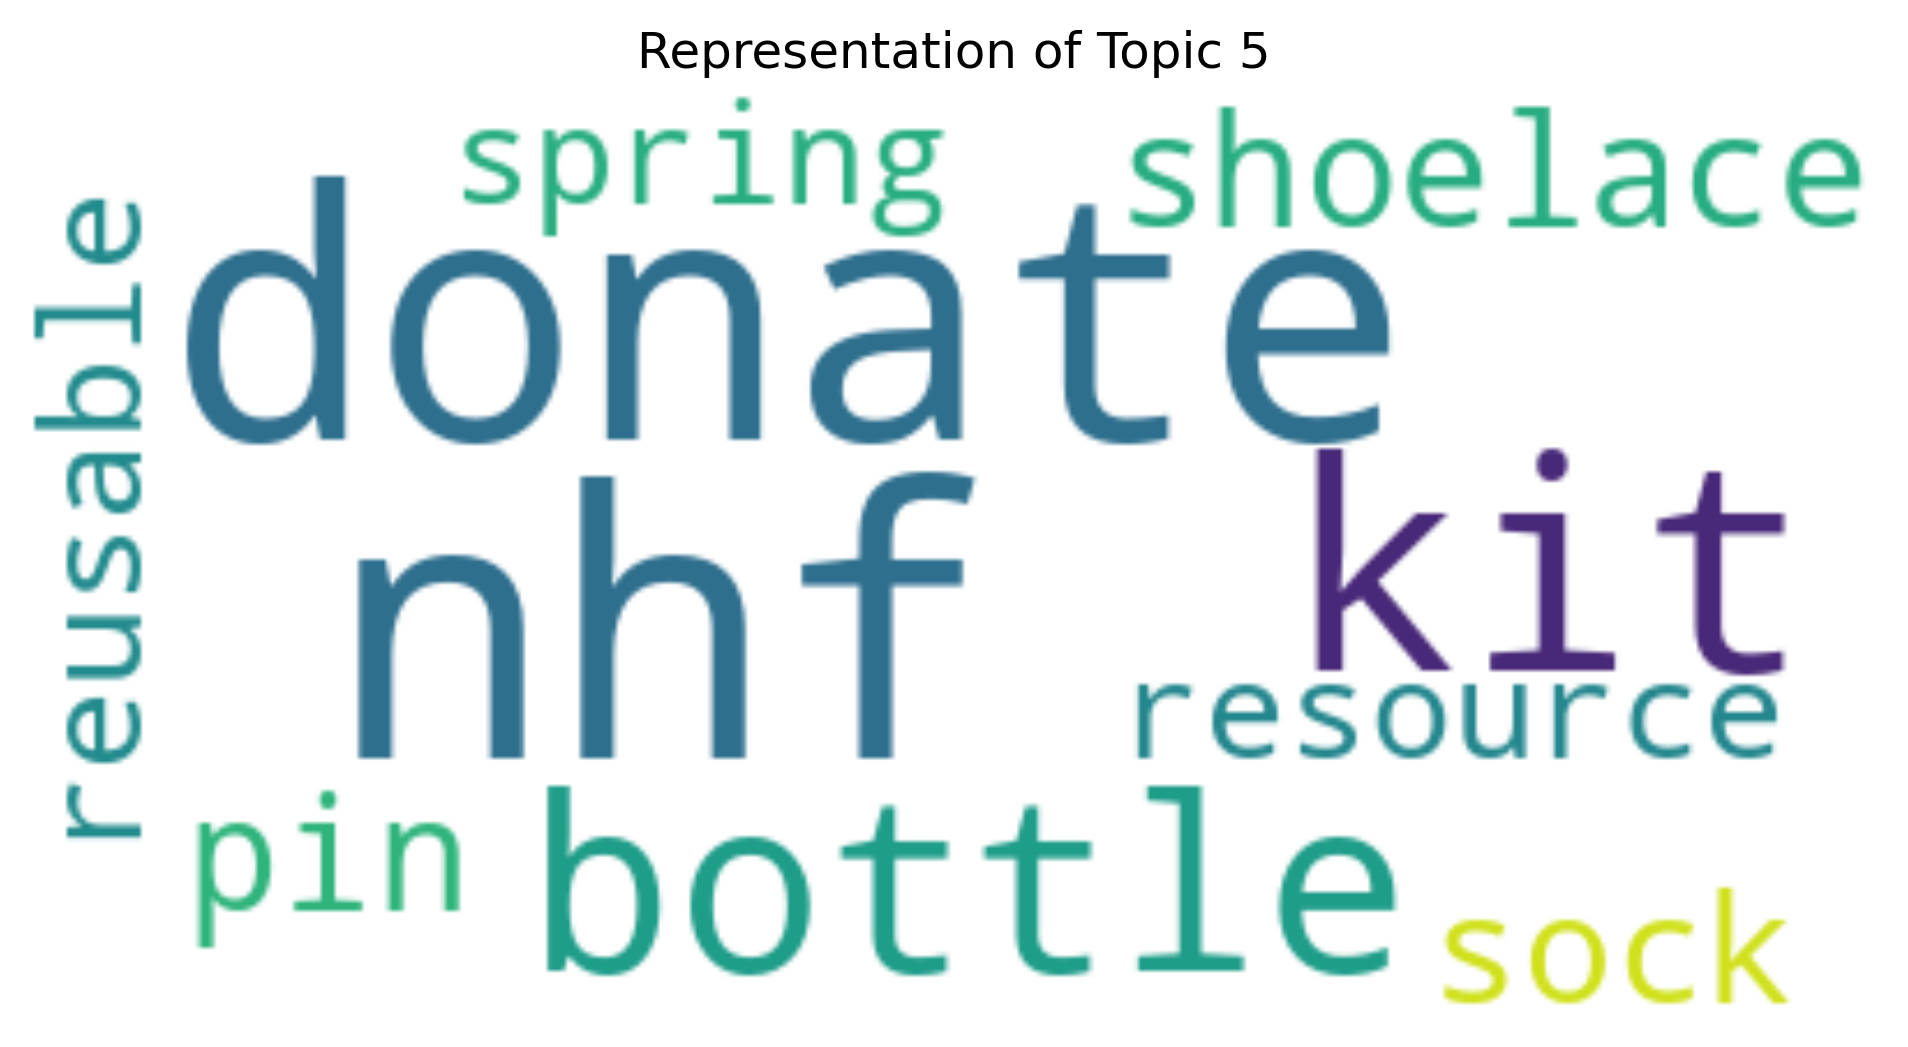

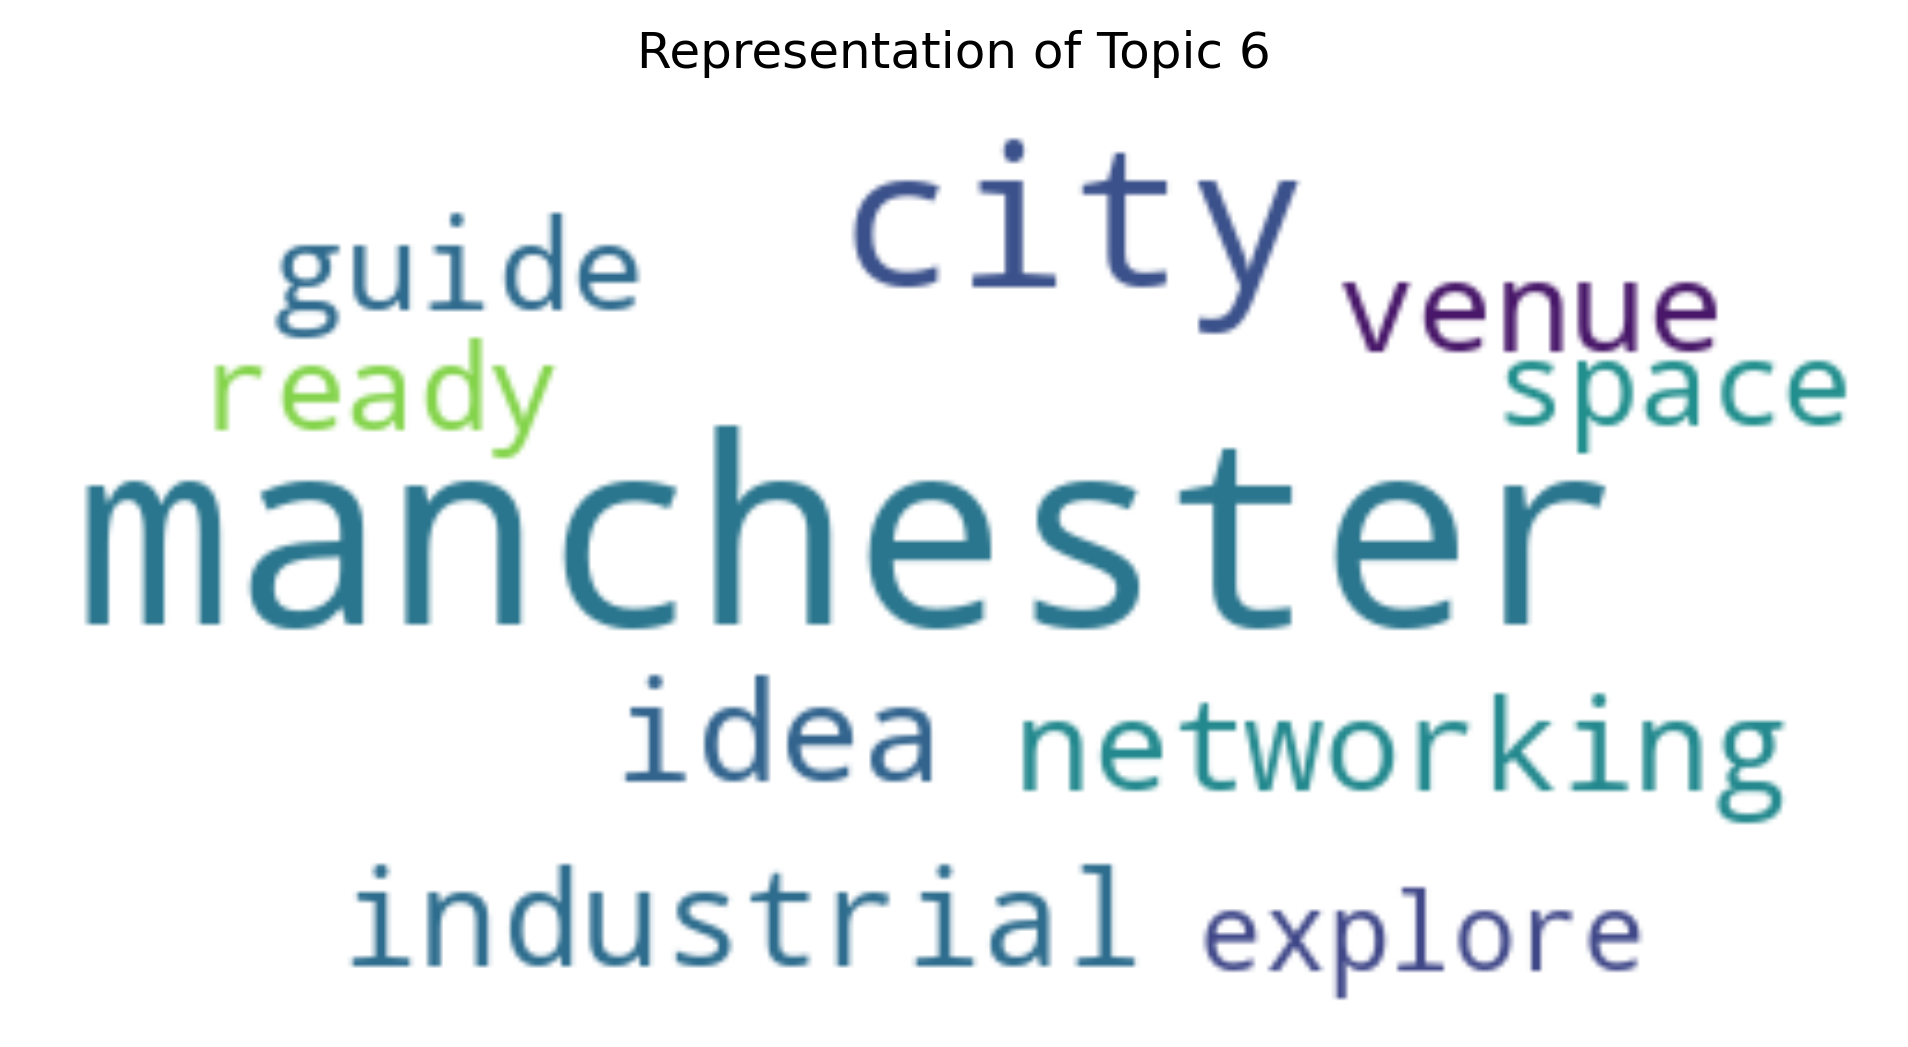

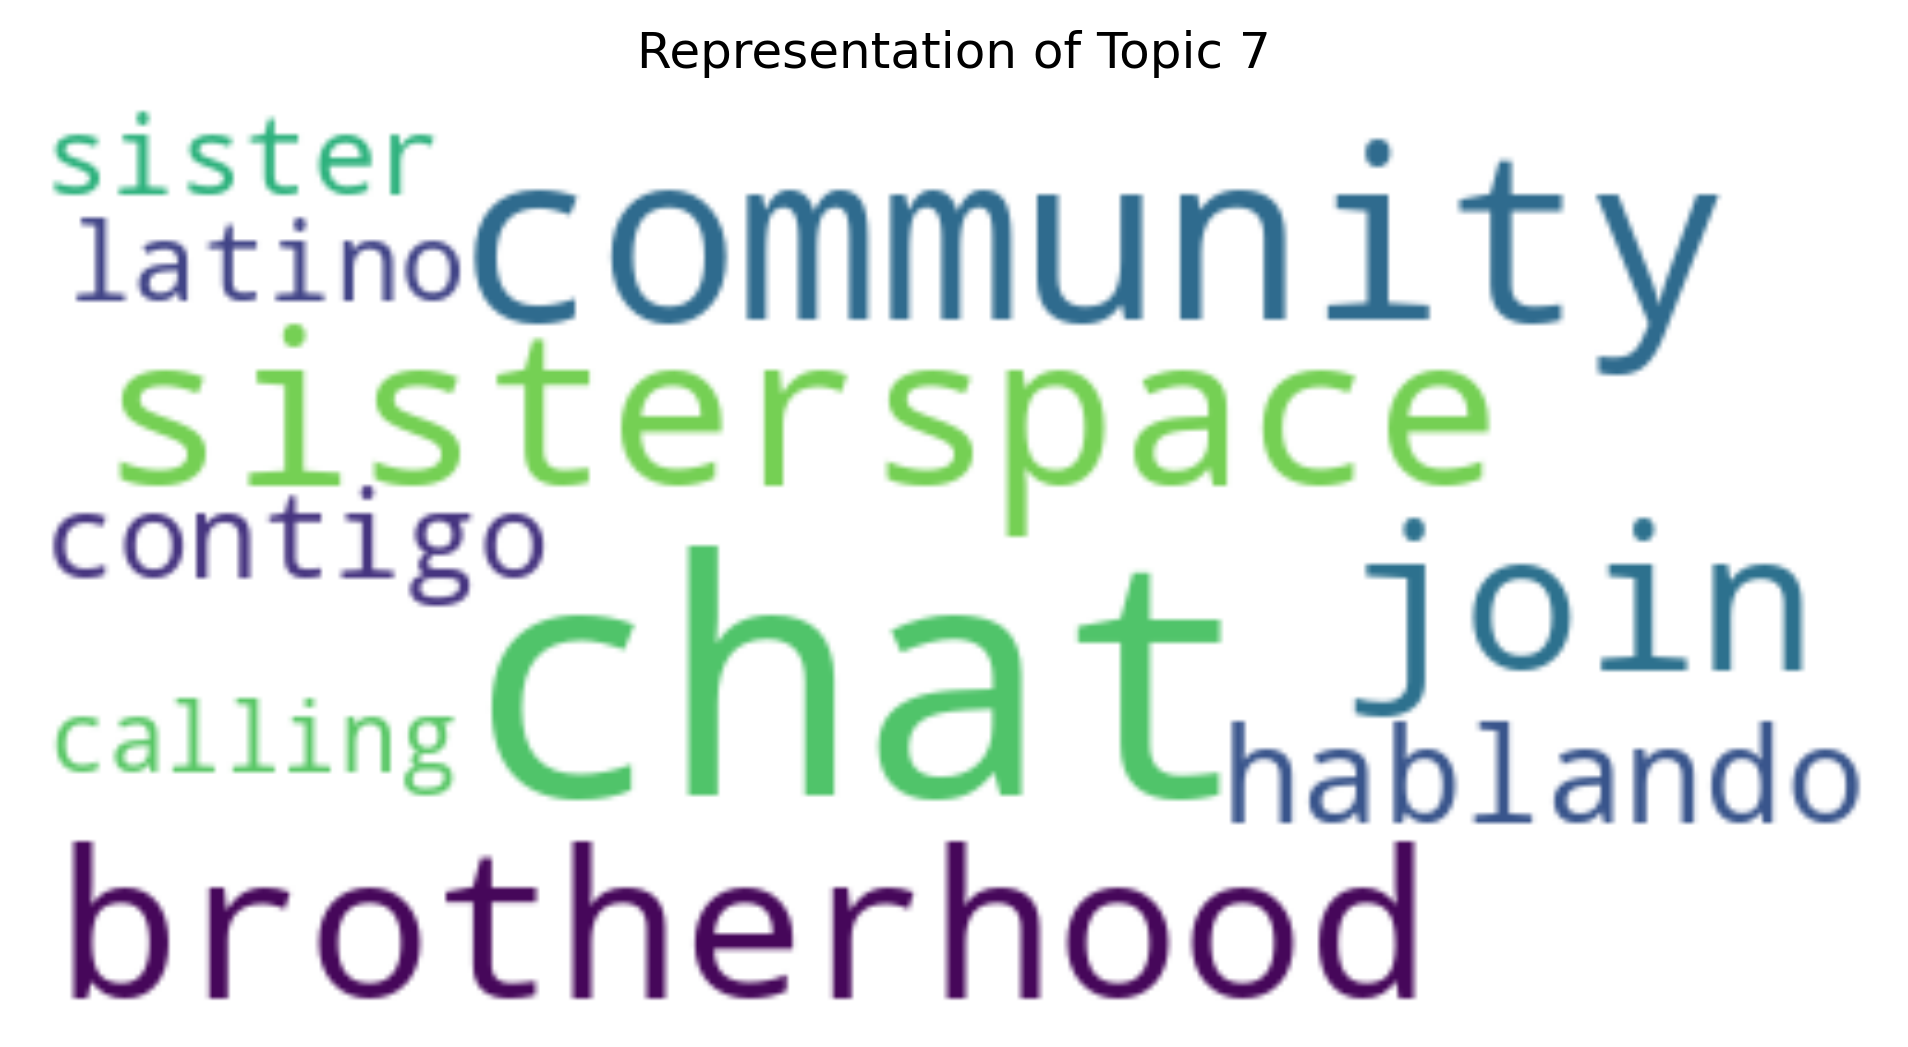

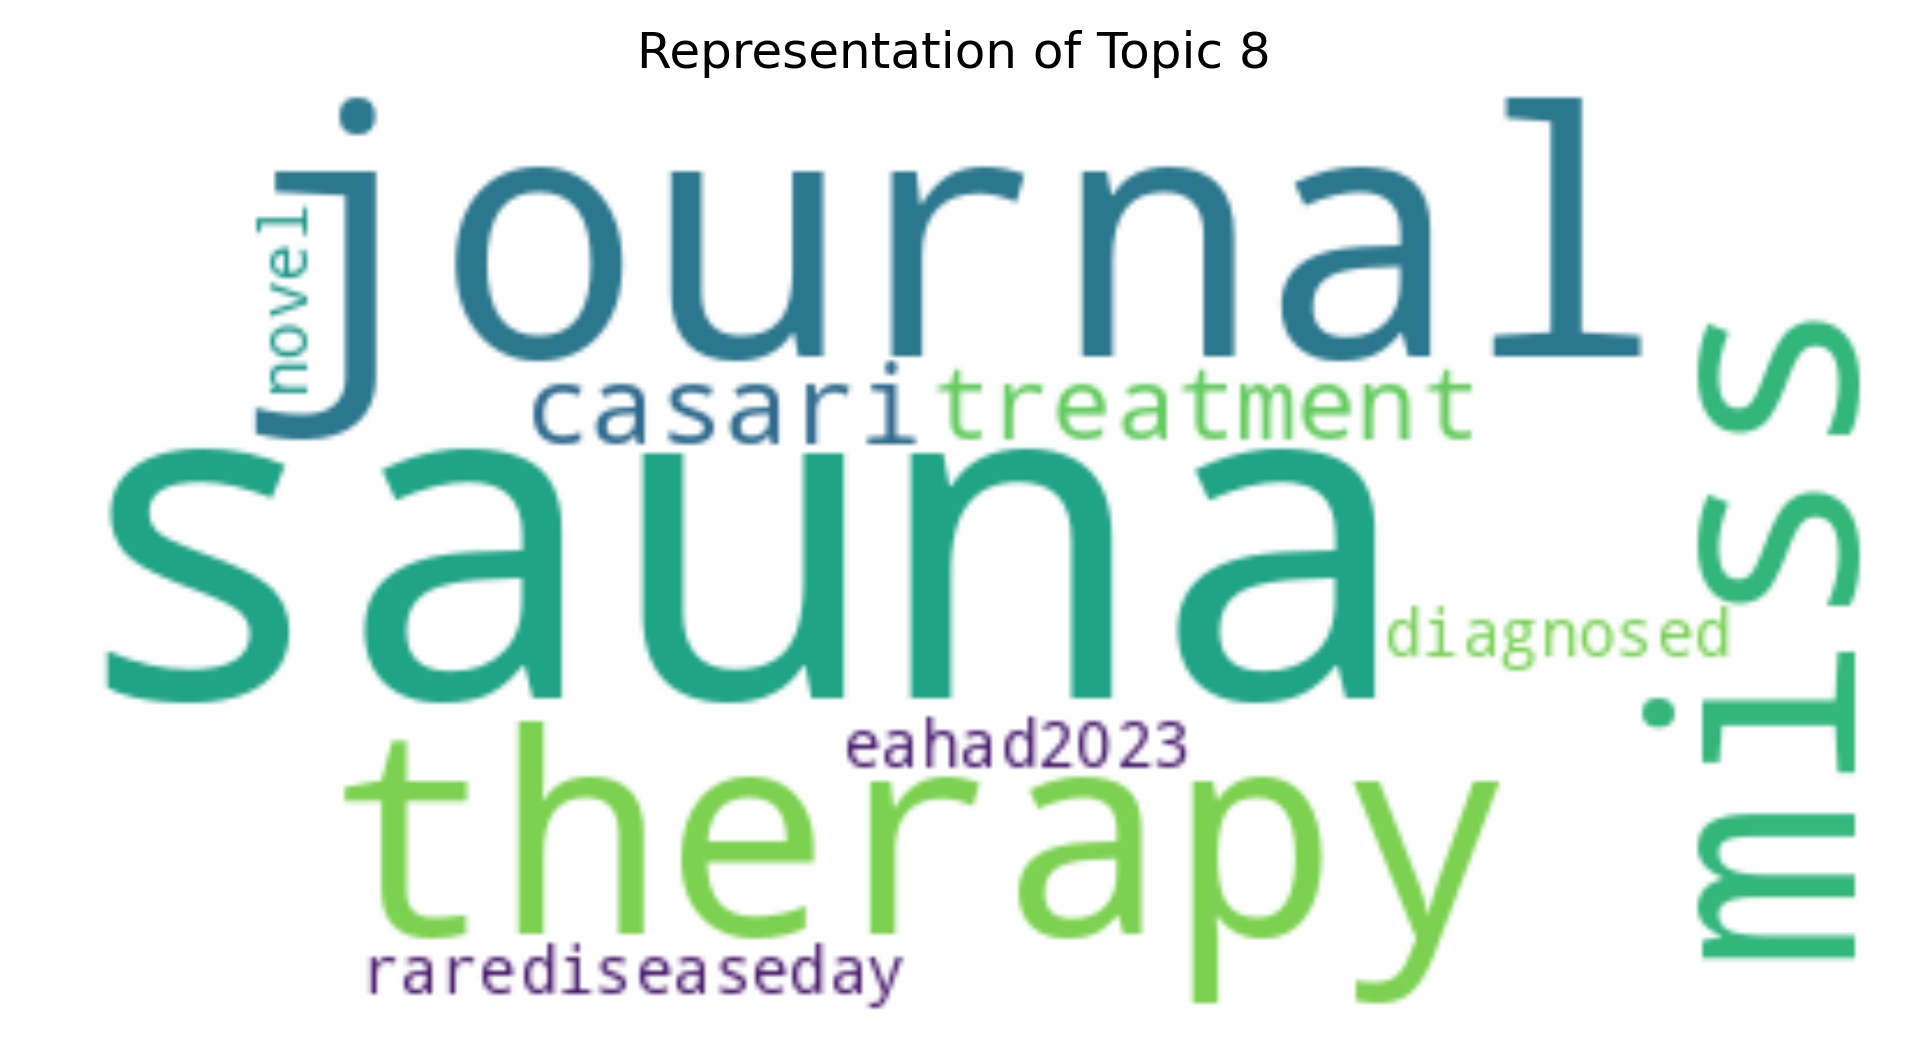

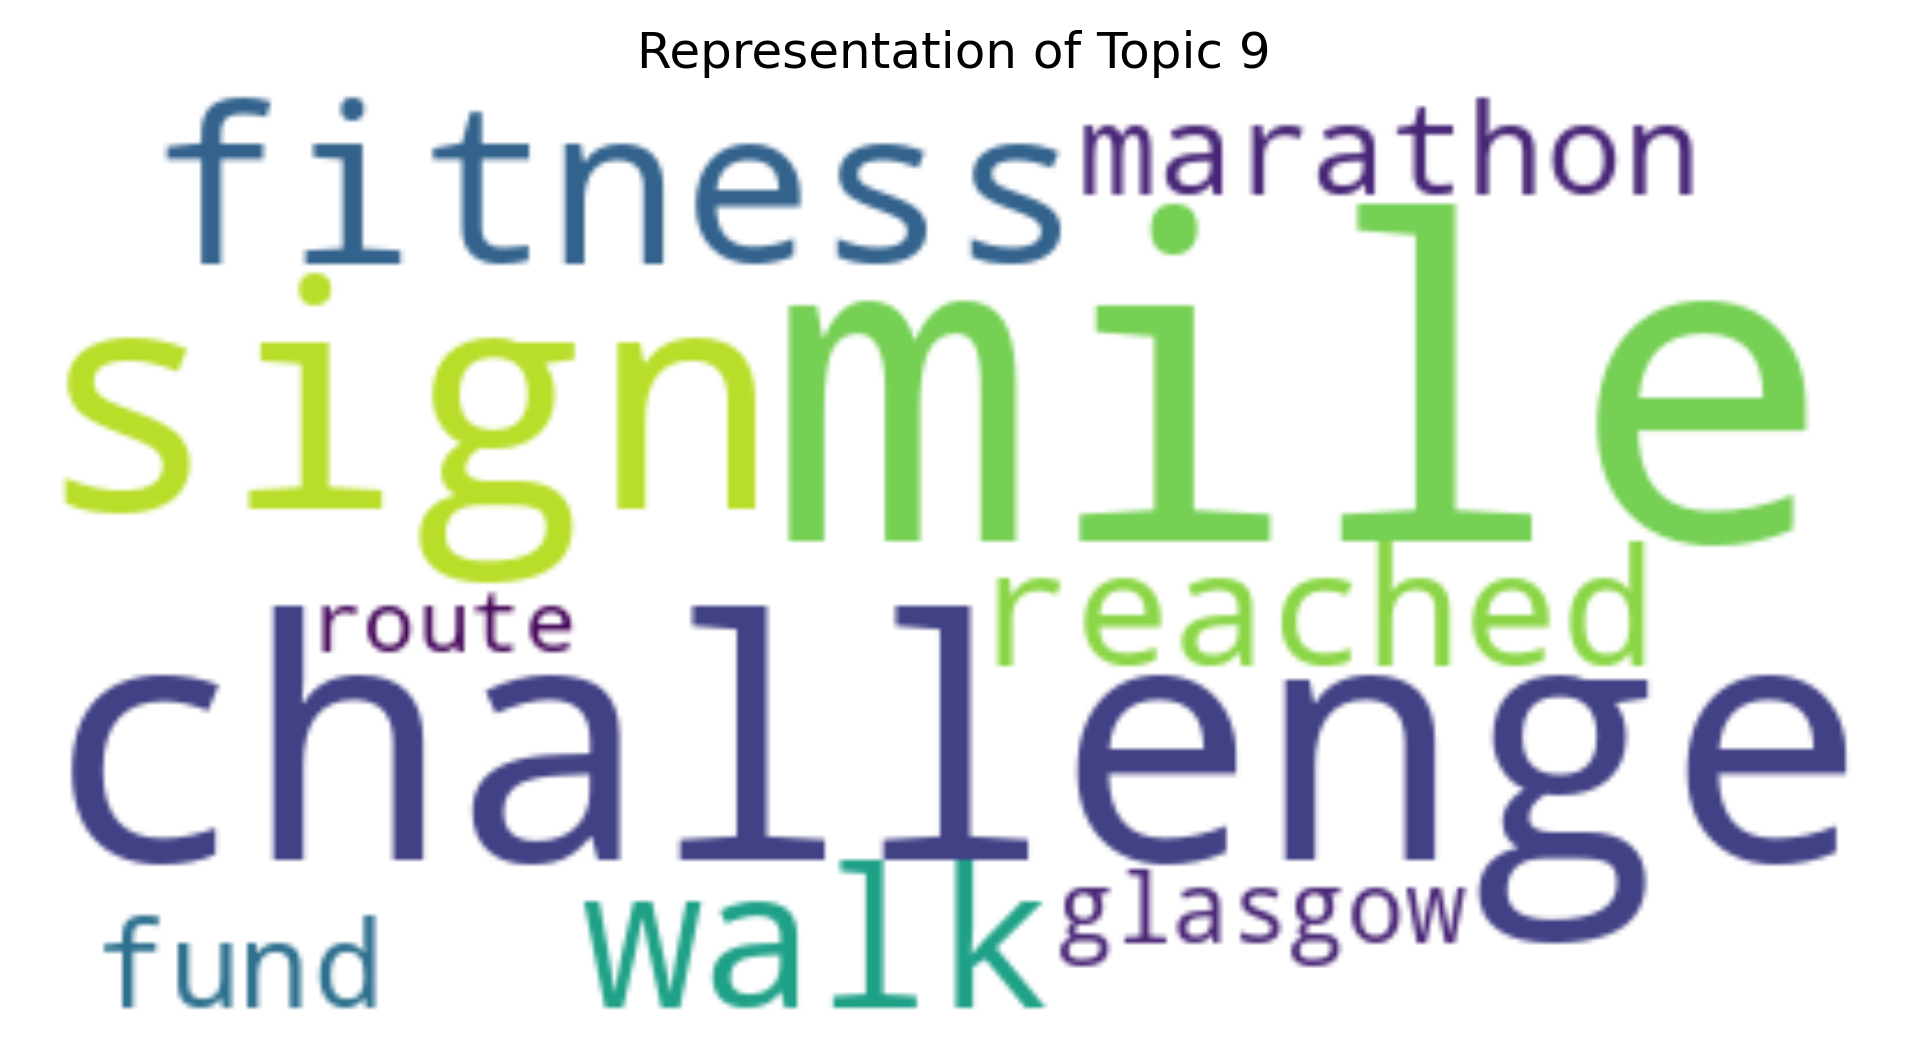

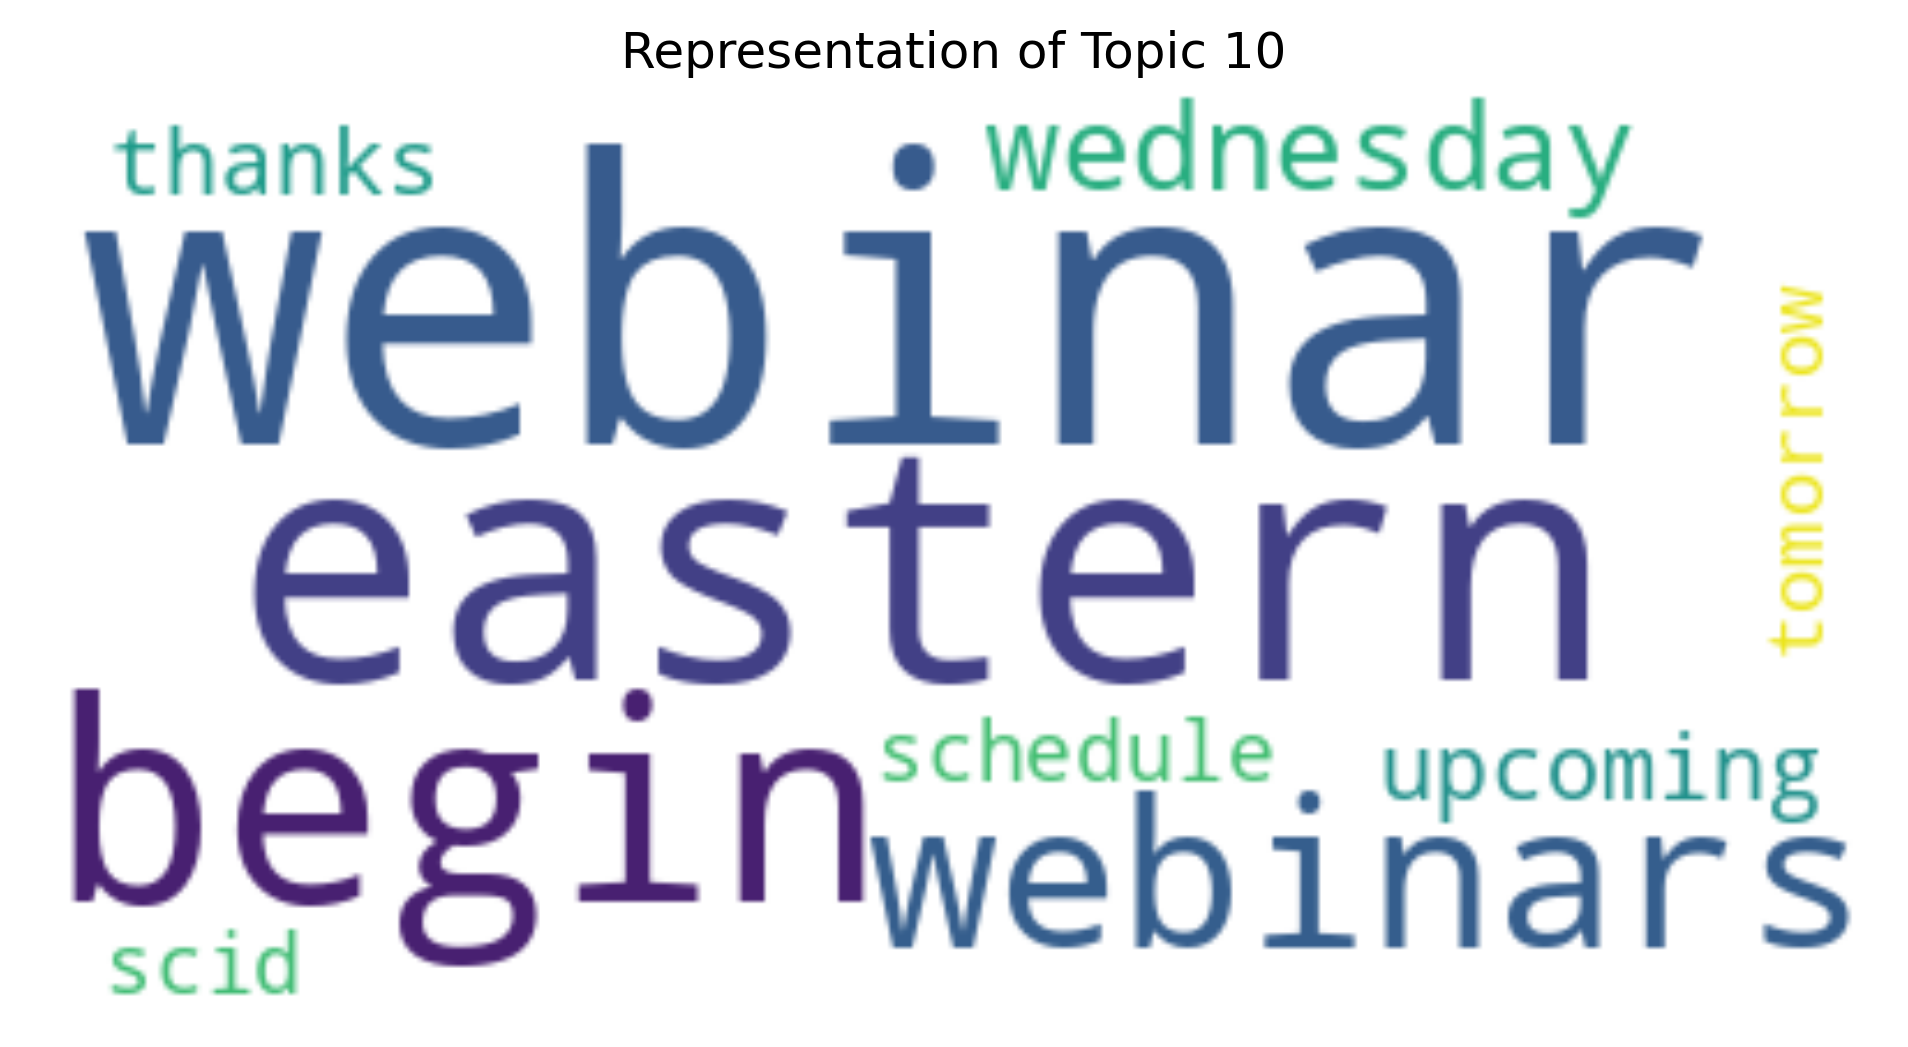

In [ ]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8, 4), dpi=300)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("Off")
    plt.title("Representation of Topic"+" "+ str(topic))
    plt.show()

#visualize the top 3 topics
for i in range(1,11):
    create_wordcloud(topic_model, topic=i)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_heatmap(n_clusters = 10)

In [ ]:
docs = tweet_list
# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

topic_words = [[words for words, _ in topic_model.get_topic(topic) if words!='']
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.8147433739606577


In [ ]:
topics_over_time = topic_model.topics_over_time(tweet_list, timestamp, nr_bins=20)

19it [01:14,  3.91s/it]


In [ ]:
topics_over_time

Topic                                              Words  Frequency  \
0       -1                king, luther, martin, closed, admin          7   
1        0  orlando, disaster, bleedingdisordersawarenessm...         12   
2        1         venture, fviii, prothrombin, dvt, biologic         14   
3        2    enewsletter, signed, subscribe, monthly, update          1   
4        3     wind, privatized, slavery, abolished, theranos          1   
..     ...                                                ...        ...   
386     14  emmahope, lisagueran, investigator, eahad2023,...          1   
387     18               reading, royal, blog, london, ticket          1   
388     27                                 column, week, , ,           1   
389     30  committee, internationalnursesday, dedication,...          1   
390     31     health, webinar, bar, womenshealthweek, sanofi          2   

                  Timestamp  
0   2023-01-01 20:27:43.020  
1   2023-01-01 20:27:43.020  
2   2023-01-01 20:27:43.020  
3   2023-01-01 20:27:43.020  
4   2023-01-01 20:27:43.020  
..                      ...  
386 2023-11-21 15:26:51.000  
387 2023-11-21 15:26:51.000  
388 2023-11-21 15:26:51.000  
389 2023-11-21 15:26:51.000  
390 2023-11-21 15:26:51.000  

[391 rows x 4 columns]

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=100)